In [1]:
import requests
from IPython.core.display import HTML
styles = requests.get(
    "https://raw.githubusercontent.com/Harvard-IACS/2021-CS109A/master/"
    "themes/static/css/cs109.css"
).text
HTML(styles)

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import (LogisticRegression, LinearRegression)
from sklearn.metrics import (accuracy_score, confusion_matrix, roc_auc_score,
                             roc_curve)
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import resample

# pandas tricks for better display
pd.options.display.max_columns = 50  
pd.options.display.max_rows = 500     
pd.options.display.max_colwidth = 100
pd.options.display.precision = 3

# pandas tricks for better display
pd.set_option('display.width', 1500)
pd.set_option('display.max_columns', 100)

# Silence FutureWarnings
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning)


# Recovering Astronomical Relations

In [3]:
processed_galaxies_df = pd.read_csv('/Users/johndinovi/Desktop/cs-109a/Classifying_Galaxies/data/preprocessed_data.csv')
processed_galaxies_df= processed_galaxies_df.drop(['Unnamed: 0', 'index'], axis=1)

In [4]:
missingness = pd.read_csv('/Users/johndinovi/Desktop/cs-109a/Classifying_Galaxies/data/missingness.csv')
missingness= missingness.drop(['Unnamed: 0'], axis=1)

Slope:  74.6649086626481


/Users/johndinovi/micromamba/envs/cs109a/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


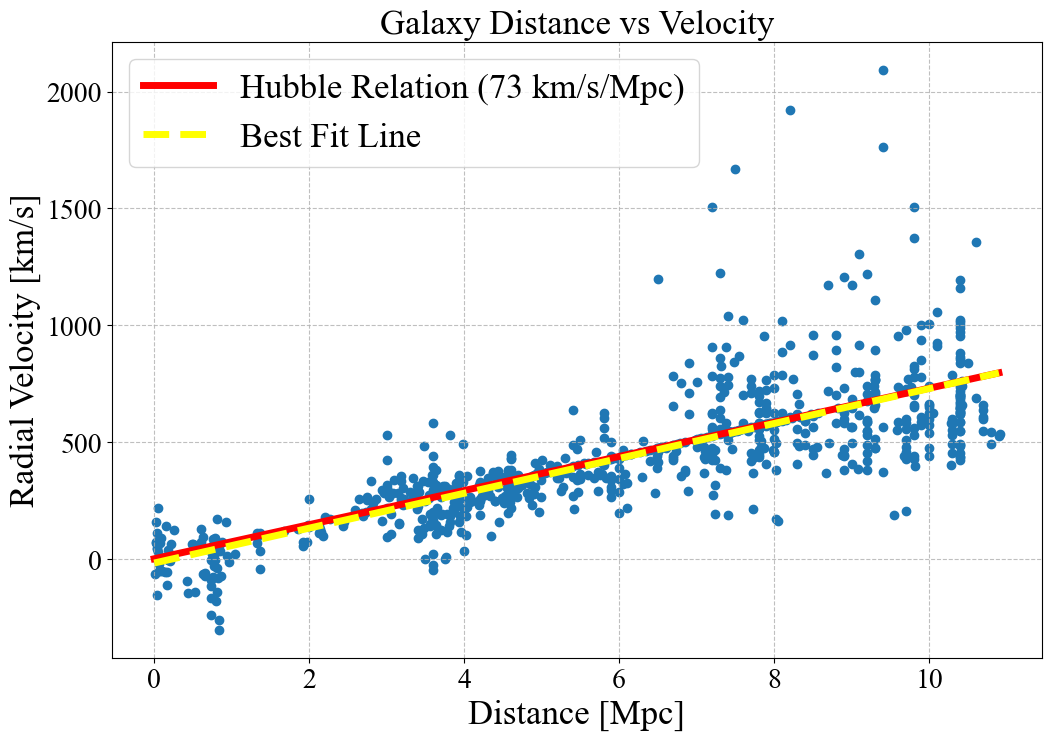

In [5]:
# recovering known astronomical relations       
plt.rcParams["font.family"] = "Times New Roman"


plt.figure(figsize=(12,8))

hubble_galaxies = processed_galaxies_df[processed_galaxies_df['Dist'] < 11]

plt.scatter(hubble_galaxies['Dist'],hubble_galaxies['Vlg'])
# plt.xlim(0,11)
# plt.ylim(-500,1100)
plt.tick_params(labelsize=20)
plt.xlabel("Distance [Mpc]",fontsize=25)
plt.ylabel("Radial Velocity [km/s]",fontsize=25)

x = np.arange(0,11,.1)
y = 73*x
plt.plot(x,y,color='red',label=r'Hubble Relation (73 km/s/Mpc)',linewidth=5)


model = LinearRegression()

# Fitting the model to the data
model.fit(hubble_galaxies['Dist'].to_frame(), hubble_galaxies['Vlg'].to_frame())

# Making predictions
y_pred = model.predict(x.reshape(-1,1))

plt.plot(x,y_pred,color='yellow',label='Best Fit Line',linewidth=5,ls='--')

plt.grid(ls='--',alpha=.8)

plt.legend(fontsize=25)

plt.title("Galaxy Distance vs Velocity",fontsize=25)
print("Slope: ",model.coef_[0][0])

Here we plot our galaxy distances vs their radial velocities. The radial velocity represents the velocity of the galaxy as it is moving away from us. It's measured by looking at the redshifts of well-known spectral emission lines. We see that as distance increases so does the radial velocity. This suggests that further away galaxies from us are moving faster. In this way, it seems like we are at the center of an expanding universe. However, the Copernican principle (which says that really we aren't all that special) points to an other interpretation: every galaxy in the universe is moving away from every other galaxy, the universe is expanding! The rate of this expansion is captured by a value called the Hubble constant, first measured in the late 1920s. The current best estimates place this value at around 73 km/s/Mpc (so galaxies 1Mpc away from us move away at a speed of 73km/s). The galaxies in our sample fit this trend very well, as seen above. A best fit line to our data gives a Hubble constant of 74.7 km/s/Mpc. So we are indeed able to recover this known astronomical relation from our data.

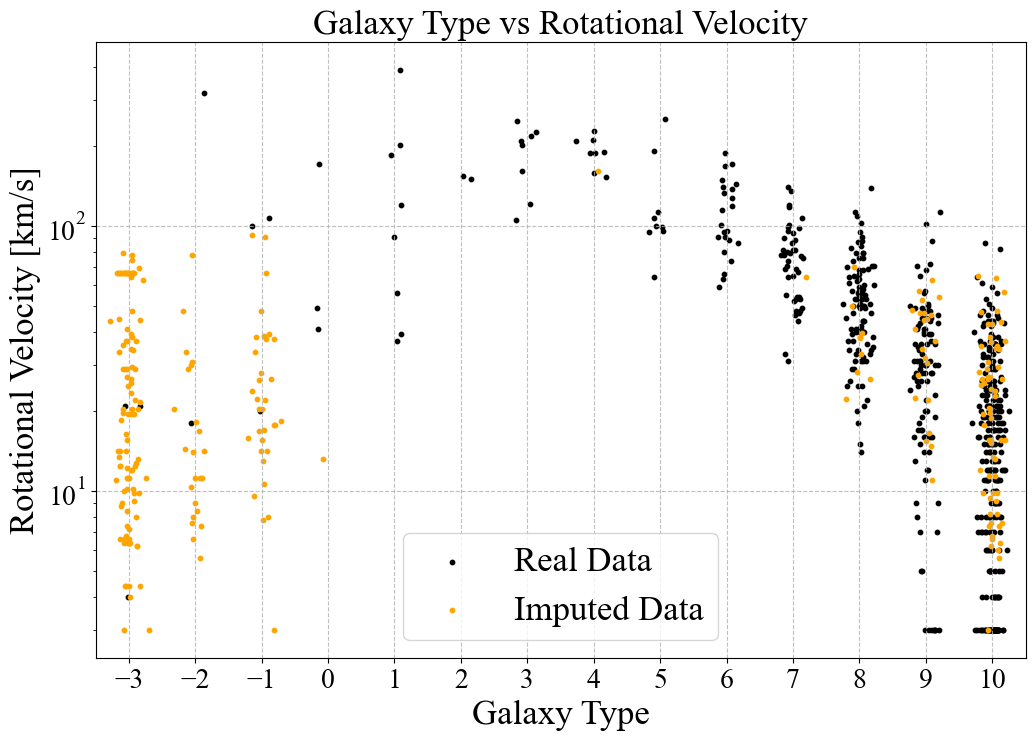

In [6]:
plt.rcParams["font.family"] = "Times New Roman"


plt.figure(figsize=(12,8))

indexes = np.where(np.array(missingness['vAmp']==False) == True)
imp_indexes = np.where(np.array(missingness['vAmp']==False) == False)

jitter = np.random.normal(0, .1, len(indexes[0]))


plt.scatter(np.array(processed_galaxies_df['TT'])[indexes]+jitter,np.array(processed_galaxies_df['vAmp'])[indexes],s=10,color='black',label='Real Data')
jitter = np.random.normal(0, .1, len(imp_indexes[0]))


plt.scatter(np.array(processed_galaxies_df['TT'])[imp_indexes]+jitter,np.array(processed_galaxies_df['vAmp'])[imp_indexes],s=10,color='orange',label='Imputed Data')


plt.xlim(-3.5,10.5)
# plt.ylim(-500,1100)
plt.tick_params(labelsize=20)
plt.xlabel("Galaxy Type",fontsize=25)
plt.ylabel("Rotational Velocity [km/s]",fontsize=25)
plt.grid(ls='--',alpha=.8)

plt.yscale('log')
plt.xticks(np.arange(-3,11,1))

plt.title('Galaxy Type vs Rotational Velocity',fontsize=25)
plt.legend(fontsize=25)
plt.show()

    

We see here that the rotational velocities of our galaxies peaks around galaxy type 2-4, which correspond to early type siral galaxies. This makes sense, as these galaxies are typically larger in size and more massive, and thus show higher rotation curves. The spread in velocities for higher galaxy types (8-10) could be due to these being irregular, which often result from a collision of two galaxies thus leading to a larger range of possible rotational velocities. 

It's also worth noting that one reason behind the larger spread could also just be the lack of data points for spiral galaxies, and the over-representation of irregular and lenticular galaxies in our sample.

We also see that the majority of our galaxies with type <0 needed to have rotational velocities imputed. This is likely because these early-type galaxies have a lower gas content, which as a result can make it hard to accurately measure a rotational amplitude. As such our data is not missing completely at random, and we don't draw any strong conclusions from the large spread and lower values of rotational velocities for these galaxies.

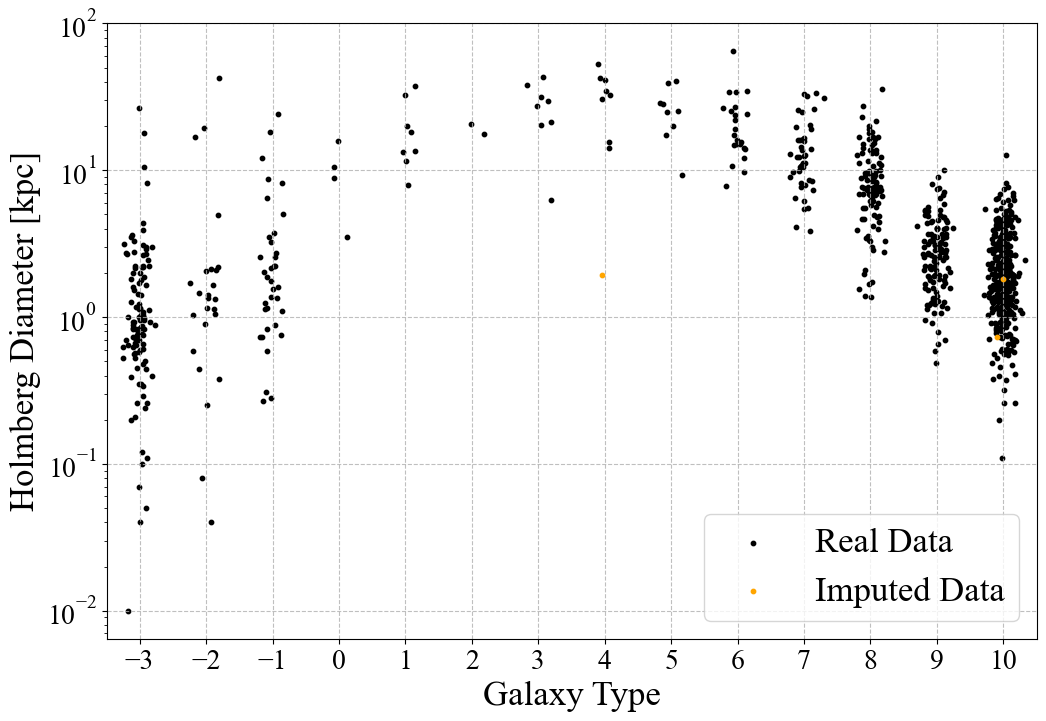

In [7]:
plt.figure(figsize=(12,8))

indexes = np.where(np.array(missingness['A26']==False) == True)
imp_indexes = np.where(np.array(missingness['A26']==False) == False)

jitter = np.random.normal(0, .1, len(indexes[0]))

plt.scatter(np.array(processed_galaxies_df['TT'])[indexes]+jitter,np.array(processed_galaxies_df['A26'])[indexes],s=10,color='black',label='Real Data')
jitter = np.random.normal(0, .1, len(imp_indexes[0]))


plt.scatter(np.array(processed_galaxies_df['TT'])[imp_indexes]+jitter,np.array(processed_galaxies_df['A26'])[imp_indexes],s=10,color='orange',label='Imputed Data')


plt.xlim(-3.5,10.5)
# plt.ylim(-500,1100)
plt.tick_params(labelsize=20)
plt.xlabel("Galaxy Type",fontsize=25)
plt.ylabel("Holmberg Diameter [kpc]",fontsize=25)
plt.grid(ls='--',alpha=.8)
plt.yscale('log')
plt.xticks(np.arange(-3,11,1))

plt.legend(fontsize=25)



Again, we see that the Holmberg Diameter peaks around the Spiral galaxies. The holmberg diamater is a measure of the size of the galaxy based on its observed surface brightness (specifically the major-axis radius at a surface brightness of 26.5 photographic mag arcsec^2). This makes sense to some degree as spiral galaxies have many young stars, contributing to a larger surface brightness.

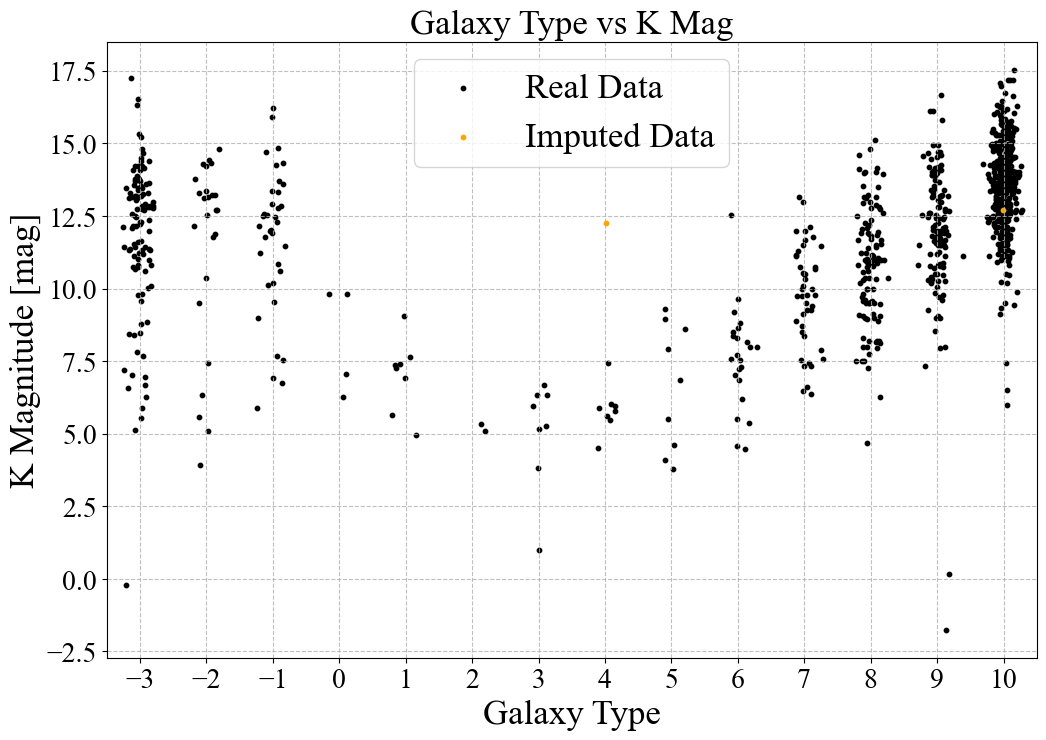

In [8]:
plt.figure(figsize=(12,8))


processed_galaxies_df["b_k"] = processed_galaxies_df['Bmag'] - processed_galaxies_df['Kmag']

# boxplot = processed_galaxies_df.boxplot(by='TT', column='b_k')
indexes = np.where(np.array(missingness['Kmag']==False) == True)
imp_indexes = np.where(np.array(missingness['Kmag']==False) == False)

jitter = np.random.normal(0, .1, len(indexes[0]))

plt.scatter(np.array(processed_galaxies_df['TT'])[indexes]+jitter,np.array(processed_galaxies_df['Kmag'])[indexes],s=10,color='black',label='Real Data')
jitter = np.random.normal(0, .1, len(imp_indexes[0]))


plt.scatter(np.array(processed_galaxies_df['TT'])[imp_indexes]+jitter,np.array(processed_galaxies_df['Kmag'])[imp_indexes],s=10,color='orange',label='Imputed Data')
plt.xlim(-3.5,10.5)
# plt.ylim(0,10)  
plt.tick_params(labelsize=20)
plt.xlabel("Galaxy Type",fontsize=25)
plt.ylabel("K Magnitude [mag]",fontsize=25)
plt.grid(ls='--',alpha=.8)


# model = LinearRegression()

# # Fitting the model to the data
# model.fit(hubble_galaxies['TT'].to_frame(), hubble_galaxies['b_k'].to_frame())

# # Making predictions
# x = np.arange(-3,11,.1)
# y_pred = model.predict(x.reshape(-1,1))

# plt.plot(x,y_pred,color='maroon',label='Best Fit Line',linewidth=5)
# plt.legend(fontsize=25)
# plt.xticks(np.arange(-3,11,1))
plt.title("Galaxy Type vs K Mag",fontsize=25)
# plt.show()
plt.xticks(np.arange(-3,11,1))

plt.legend(fontsize=25)


The K wavelength band in astronomy is centered at 2.2 micrometers. This is out of the optical and into the infrared. Galaxies that emit strongly in the infrared are those that have high dust contents, as dust preferentially filters out the shorter wavelength light. This is the case for spiral galaxies, which have high dust contents. This can be seen in the above plot, where spiral galaxies have the leowst K Magnitude (which actually corresponds to being brighter in that band, an inverse relationship).

Text(0.5, 1.0, 'Galaxy Type vs Surface Hydrogen Density')

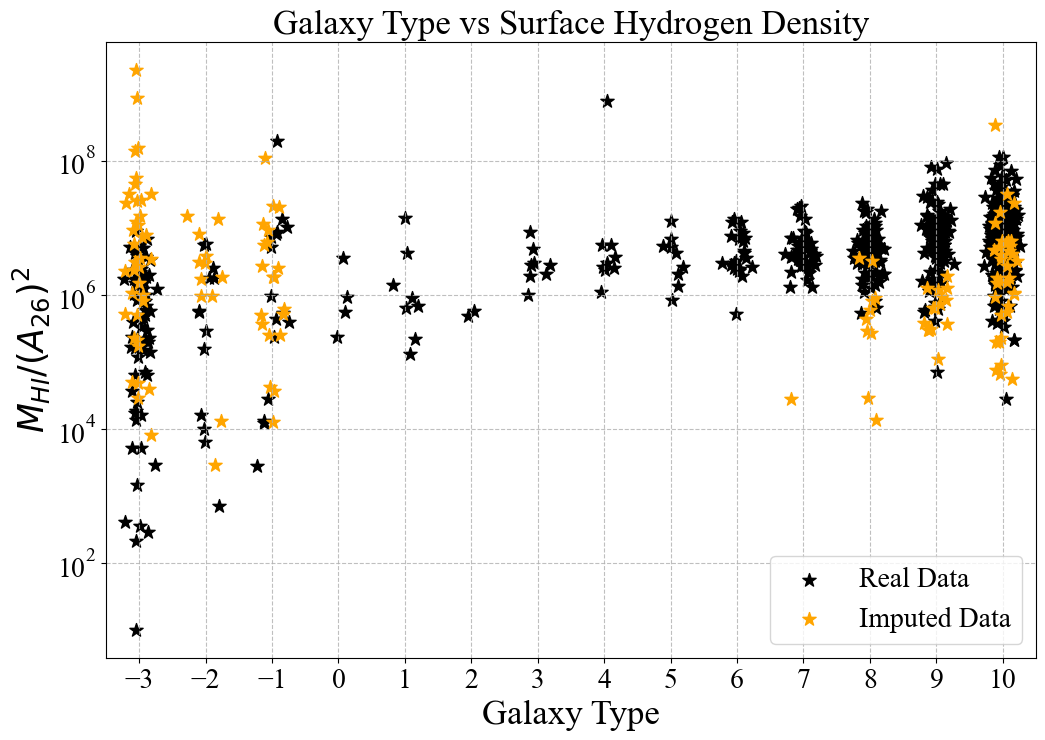

In [9]:
# SFR vs type
plt.figure(figsize=(12,8))

hydrogen_density = 10**processed_galaxies_df['MHI']/(processed_galaxies_df['A26']**2)
processed_galaxies_df['hd'] = hydrogen_density


indexes = np.where(np.array(missingness['MHI']==False) == True)
imp_indexes = np.where(np.array(missingness['MHI']==False) == False)

jitter = np.random.normal(0, .1, len(indexes[0]))

plt.scatter(np.array(processed_galaxies_df['TT'])[indexes]+jitter,np.array(processed_galaxies_df['hd'])[indexes],s=100,color='black',label='Real Data',marker='*')
jitter = np.random.normal(0, .1, len(imp_indexes[0]))


plt.scatter(np.array(processed_galaxies_df['TT'])[imp_indexes]+jitter,np.array(processed_galaxies_df['hd'])[imp_indexes],s=100,color='orange',label='Imputed Data',marker='*')


plt.xlim(-3.5,10.5)
# plt.ylim(-500,1100)
plt.tick_params(labelsize=20)
plt.xlabel("Galaxy Type",fontsize=25)
plt.ylabel(r"$M_{HI}/(A_{26})^2$",fontsize=25)
plt.grid(ls='--',alpha=.8)  
plt.xticks(np.arange(-3,11,1))
plt.yscale('log')
plt.legend(fontsize=20)
plt.title("Galaxy Type vs Surface Hydrogen Density",fontsize=25)

Here we see that there is somewhat of a relationship between galaxy type and the hydrogen mass divided by the length of the galaxy squared. It's been previously noted that this parameter (hydrogen mass/area, or average hydrogen surface density) is a good proxy for star formation rate (SFR) in a galaxy [(Robert & Haynes 1994)](https://ui.adsabs.harvard.edu/abs/1994ARA%26A..32..115R/abstract). We see that the average hydrogen surface density seems to increase for both smaler and larger galaxy types, corresponding to lenticular and irregular galaxies. This makes sense with known galaxy type characteristics. Typically, irregular galaxies are of lower masses and luminosities than spiral ones, and are undergoing relatively intense star formation activity. 

We also see that there is a spread in surface density at both ends of the morphological scale. Some of this can also be explained by galaxy evolution predictions; lenticular galaxies are theorized to potentially have large amounts of their hydrogen sweeped out [(van den Bergh 2009)](https://iopscience.iop.org/article/10.1088/0004-637X/702/2/1502), which could lead to a large spread in SFR.

# Preliminary Models

In [10]:
data = pd.read_csv("../data/preprocessed_data.csv")
data.head()

,Unnamed: 0,index,TT,Mcl,Tdw,FUV,Bmag,Hamag,Kmag,HImag,W50,HRV,Dist,A26,i,vAmp,<Bmu>,M26,MHI,Vlg,Ti5
0,0,2,10,Ir,L,17.57,16.80,19.910,14.02,15.66,34.0,335.0,8.47,2.78,33.0,21.0,25.2,8.170,7.920,619.0,-1.2
1,1,3,9,Im,N,12.80,11.03,15.560,9.00,11.19,53.0,-122.0,0.97,3.21,90.0,22.0,24.8,8.270,7.830,-16.0,0.2
2,2,4,-3,Sph,L,23.00,17.00,24.098,12.49,18.32,131.8,-332.0,1.36,0.63,10.0,66.4,26.2,8.436,6.688,-44.0,0.5
3,3,5,9,Im,N,16.08,15.15,17.210,12.74,15.28,53.0,726.0,7.70,2.65,78.0,23.0,24.1,8.200,7.990,769.0,-1.2
4,4,6,10,Ir,L,20.28,18.90,24.706,16.29,18.21,16.0,258.0,5.40,0.53,70.0,3.0,24.9,5.640,6.510,486.0,-1.3


## Data Preparation and Standardization

In [11]:
# Define list of predictors for tt
log_reg_predictors_tt = ['FUV','Bmag','Hamag','Kmag','HImag','W50','HRV','Dist','A26','i','vAmp','<Bmu>','M26','MHI','Vlg','Ti5']

# Splitting the dataset for 'TT' as the response variable
X, y = data[log_reg_predictors_tt], data['TT']

# train_test_split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=109, test_size=0.2, shuffle=True)


# Displaying the shapes of the datasets and first few rows of the training sets
data_shapes = pd.DataFrame({
    "Full dataset": [data.shape],
    "Train (TT)": [X_train.shape], 
    "Test (TT)": [X_test.shape],
})
display(data_shapes)


,Full dataset,Train (TT),Test (TT)
0,"(864, 21)","(691, 16)","(173, 16)"


In [12]:
# Instantiate a scaler
standardscaler = StandardScaler().fit(X_train)

# Standardize the data for use
std_X_train = standardscaler.transform(X_train)
std_X_test = standardscaler.transform(X_test)


## Logistic Regression Classification

In [13]:
# Initialize and train the Logistic Regression model
log_reg_tt = LogisticRegression(random_state=109, penalty=None, max_iter=4000)
log_reg_tt.fit(std_X_train, y_train)


LogisticRegression(max_iter=4000, penalty=None, random_state=109)

In [14]:
# Train and Test Scores
acc_train_log_reg_tt = log_reg_tt.score(std_X_train, y_train)
acc_test_log_reg_tt = log_reg_tt.score(std_X_test, y_test)

In [15]:
log_reg_tt_intercept = np.array(log_reg_tt.intercept_).flatten()[0]
log_reg_tt_coefs = log_reg_tt.coef_.flatten()

In [16]:
print(
    "The intercept and coefficients for the 'log_reg_tt' model are:"
    "\n\n\t{:<20}{:.4f}".format(
        "intercept", log_reg_tt_intercept
    )
)
for predictor, coef in zip(log_reg_predictors_tt, log_reg_tt_coefs):
    print("\t{:<20}{:.4f}".format(predictor, coef))

print(
    "\nThe classification accuracies for 'log_reg_tt' are:"
    "\n\n\tTrain\t{:.4f}\n\tTEST\t{:.4f}"
    .format(acc_train_log_reg_tt, acc_test_log_reg_tt)
)

The intercept and coefficients for the 'log_reg_tt' model are:

	intercept           36.0687
	FUV                 -1.2753
	Bmag                6.2513
	Hamag               2.4598
	Kmag                0.1270
	HImag               -6.6057
	W50                 -1.8143
	HRV                 -2.5716
	Dist                -0.5795
	A26                 4.7873
	i                   0.3510
	vAmp                8.3551
	<Bmu>               1.8314
	M26                 -11.8095
	MHI                 -7.3944
	Vlg                 2.2027
	Ti5                 2.6887

The classification accuracies for 'log_reg_tt' are:

	Train	0.7149
	TEST	0.6185


In [17]:
# create dict for storing test scores for each Q4 model
overall_scores_train = {"logistic_model": acc_train_log_reg_tt}
overall_scores_test = {"logistic_model": acc_test_log_reg_tt}

## kNN Classification

In [18]:
# Instantiate a kNN Classifier
k = 10
knn_class = KNeighborsClassifier(n_neighbors=k).fit(std_X_train, y_train)

# Calculate the train and test scores for kNN Classifier
knn_train_score = knn_class.score(std_X_train, y_train)
knn_test_score = knn_class.score(std_X_test, y_test)


In [19]:
print(
    "The classification accuracies for 'knn_model' where k={} "
    "are:\n\n\tTrain\t{:.4f}\n\tTEST\t{:.4f}"
    .format(
        k, knn_train_score, knn_test_score
    )
)

# store for overall
overall_scores_train["kNN_model"] = knn_train_score
overall_scores_test["kNN_model"] = knn_test_score

The classification accuracies for 'knn_model' where k=10 are:

	Train	0.6614
	TEST	0.5954


## Random Forest Classification

In [20]:
# Instantiate the random forest classifier
n_estimators=1000
rf_class = RandomForestClassifier(n_estimators=n_estimators, random_state=109).fit(std_X_train, y_train)

# Calculate the classification accuracy on train and test data
rf_train_acc = rf_class.score(std_X_train, y_train)
rf_test_acc = rf_class.score(std_X_test, y_test)

# print model results summary
print(
    "The random forest with trees of unspecified max-depth trained on the \n"
    "full training set, achieves the following accuracy scores:"
    "\n\n\ttrain\t{:.4f}\n\tTEST\t{:.4f}".format(
        rf_train_acc,
        rf_test_acc,
    )
)

# Store the accuracies in the overall scores dictionary
overall_scores_train['random forest'] = rf_train_acc
overall_scores_test['random forest'] = rf_test_acc

The random forest with trees of unspecified max-depth trained on the 
full training set, achieves the following accuracy scores:

	train	1.0000
	TEST	0.6936


## Bagging

In [21]:
# Bagging function from homework 
def bagger(
    X_train: np.ndarray,
    y_train: np.ndarray,
    X_test: np.ndarray,
    random_seed: int = 109,
    n_trees: int = 1000
) -> (pd.DataFrame, pd.DataFrame, list):
    
    # set random seed for replicable results
    np.random.seed(random_seed)
    
    # instantiate arrays and list for storing results
    bagging_train = np.zeros((X_train.shape[0], n_trees)).astype(int)
    bagging_test = np.zeros((X_test.shape[0], n_trees)).astype(int)

    bagging_models_list = []

    # perform n bootstraps
    for i in range(n_trees):
        # generate bootstrapped model
        bootstrapped_X, bootstrapped_y = resample(X_train, y_train, random_state=109)
        fitted_model = DecisionTreeClassifier(
            random_state=109
        ).fit(bootstrapped_X, bootstrapped_y)
        bagging_models_list.append(fitted_model)

        # predict on full training and test sets and store
        # results to arrays
        bagging_train[:,i] = fitted_model.predict(X_train)
        bagging_test[:,i] = fitted_model.predict(X_test)
    
    # convert arrays to pandas dataframes as required
    bagging_train_df = pd.DataFrame(
        bagging_train[:, :],
        columns=[f"model{x}" for x in range(n_trees)],
    )
    bagging_test_df = pd.DataFrame(
        bagging_test[:, :],
        columns=[f"model{x}" for x in range(n_trees)],
    )
    
    return bagging_train_df, bagging_test_df, bagging_models_list


In [22]:
# generate predictions using bagger function
bagging_train_df, bagging_test_df, bagging_models_list = bagger(X_train=std_X_train, y_train=y_train, X_test=std_X_test, random_seed=109)

In [23]:
# Calculate train predictions and accuracy, rounding the mean across models to nearest integer
bag_train_predictions = np.round(np.mean(bagging_train_df, axis=1), 0).reset_index().iloc[:, 1]
bag_train_accuracy = np.mean(bag_train_predictions.astype(int) == y_train.reset_index().iloc[:, 1])

# Calculate test predictions and accuracy, rounding the mean across models to nearest integer
bag_test_predictions = np.round(np.mean(bagging_test_df, axis=1), 0).reset_index().iloc[:, 1]
bag_test_accuracy = np.mean(bag_test_predictions.astype(int) == y_test.reset_index().iloc[:, 1])

In [24]:
# Store train and test accuracies
overall_scores_train['bagging'] = bag_train_accuracy
overall_scores_test['bagging'] = bag_test_accuracy

# print summary of results
print(
    f"Bagging 1,000 trees of unspecified tree depth achieves "
    f"the following accuracy scores:\n\n\ttrain\t"
    f"{bag_train_accuracy:.4f}\n\tTEST\t"
    f"{bag_test_accuracy:.4f}\n"
)

Bagging 1,000 trees of unspecified tree depth achieves the following accuracy scores:

	train	0.8090
	TEST	0.5029



In [25]:
# Printing the train accuracies
print("The TRAIN accuracies for the models are:\n")
for key, value in overall_scores_train.items():
    print("\t{:<25}{:.4f}".format(key, value))

# Printing the test accuracies
print("\nThe TEST accuracies for the models are:\n")
for key, value in overall_scores_test.items():
    print("\t{:<25}{:.4f}".format(key, value))


The TRAIN accuracies for the models are:

	logistic_model           0.7149
	kNN_model                0.6614
	random forest            1.0000
	bagging                  0.8090

The TEST accuracies for the models are:

	logistic_model           0.6185
	kNN_model                0.5954
	random forest            0.6936
	bagging                  0.5029


## Confusion Matrix for Random Forest Model

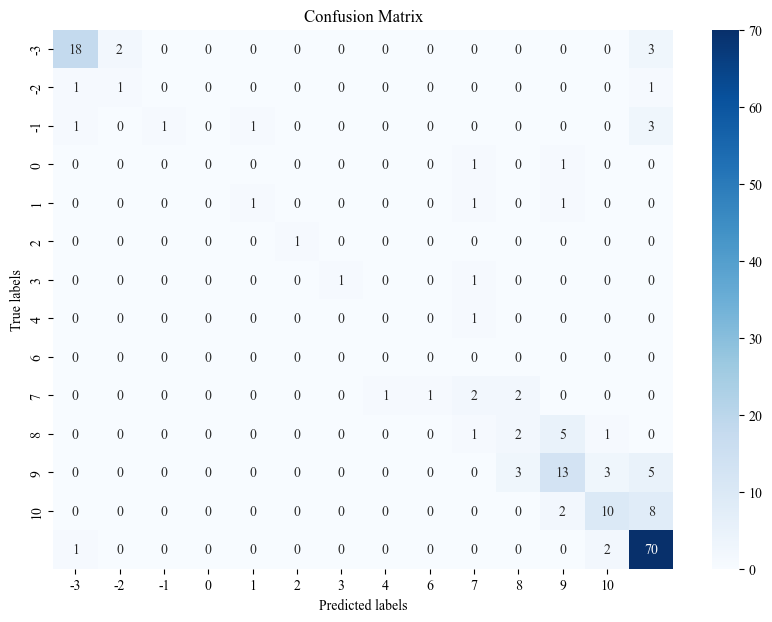

In [26]:
# Compute the confusion matrix
cm = confusion_matrix(y_test, rf_class.predict(std_X_test))

# Plotting using seaborn for a more aesthetic view
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=sorted(list(set(y_test))), yticklabels=sorted(list(set(y_test))))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Stratifid k-Fold Resampling with Confusion Matrix

In [27]:
# Initialize Random Forest Classifier
rf = RandomForestClassifier(n_estimators=1000, random_state=109)

# Initialize StratifiedKFold
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=109)

# Define the unique y values
unique_classes_tt = np.unique(y)

# Initialize the confusion matrix
total_cm = np.zeros((15, 15)) # Assuming binary classification, adjust size if necessary

# Loop over each fold
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Train the model
    rf.fit(X_train, y_train)

    # Make predictions
    predictions = rf.predict(X_test)

    # Update confusion matrix
    cm = confusion_matrix(y_test, predictions, labels=unique_classes_tt)
    total_cm += cm

# Calculate accuracy confusion matrix
avg_cm = total_cm / n_splits
cm_sum = np.sum(avg_cm, axis=1)
cm_acc = np.round(avg_cm / cm_sum, 2)


/Users/johndinovi/micromamba/envs/cs109a/lib/python3.11/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


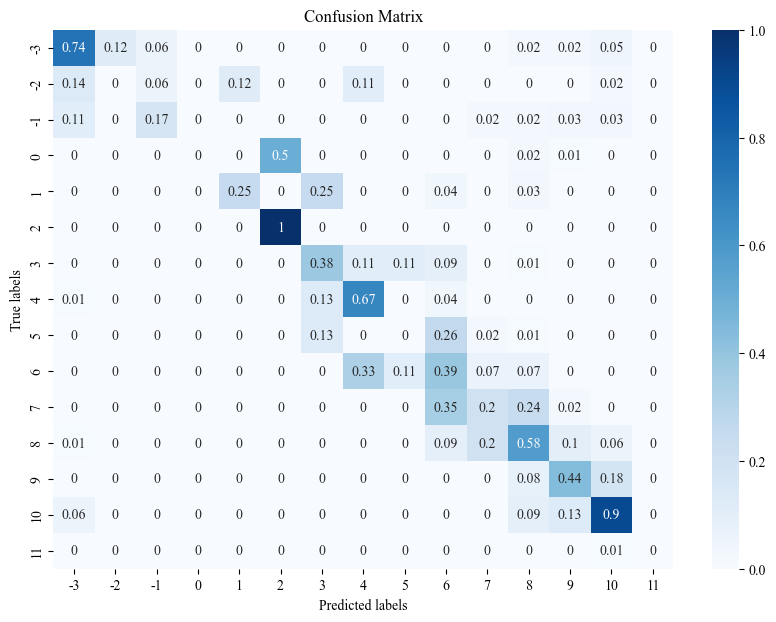

In [28]:
# Plot the confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(cm_acc, annot=True, fmt='g', cmap='Blues', xticklabels=unique_classes_tt, yticklabels=unique_classes_tt)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

## Prediction on Hubble Class (Lenticular, Spiral, Irregular) --> ([-3,-1],[0,7],[8,11])

In [29]:
# One hot encode the galaxy types for the data set --> set into a copy of the X data
y_c = y.copy()
X_c = X.copy()

gal_type = [0] * len(y_c)

for i, g_type in enumerate(y):
    if g_type <= 1:
        gal_type[i] = 'lenticular'
    elif g_type >= 0 and g_type <= 7:
        gal_type[i] = 'spiral'
    else:
        gal_type[i] = 'irregular'
        
X_c['gal_type'] = gal_type
X_c = pd.get_dummies(X_c)
X_c[['gal_type_irregular', 'gal_type_lenticular', 'gal_type_spiral']] = X_c[['gal_type_irregular', 'gal_type_lenticular', 'gal_type_spiral']].astype(int)
X_c.head()


,FUV,Bmag,Hamag,Kmag,HImag,W50,HRV,Dist,A26,i,vAmp,<Bmu>,M26,MHI,Vlg,Ti5,gal_type_irregular,gal_type_lenticular,gal_type_spiral
0,17.57,16.80,19.910,14.02,15.66,34.0,335.0,8.47,2.78,33.0,21.0,25.2,8.170,7.920,619.0,-1.2,1,0,0
1,12.80,11.03,15.560,9.00,11.19,53.0,-122.0,0.97,3.21,90.0,22.0,24.8,8.270,7.830,-16.0,0.2,1,0,0
2,23.00,17.00,24.098,12.49,18.32,131.8,-332.0,1.36,0.63,10.0,66.4,26.2,8.436,6.688,-44.0,0.5,0,1,0
3,16.08,15.15,17.210,12.74,15.28,53.0,726.0,7.70,2.65,78.0,23.0,24.1,8.200,7.990,769.0,-1.2,1,0,0
4,20.28,18.90,24.706,16.29,18.21,16.0,258.0,5.40,0.53,70.0,3.0,24.9,5.640,6.510,486.0,-1.3,1,0,0


In [30]:
# Separate the 3 different y values
y_lenticular, X_c = X_c[['gal_type_lenticular']], X_c.drop(['gal_type_lenticular'], axis=1)
y_irregular, X_c = X_c[['gal_type_irregular']], X_c.drop(['gal_type_irregular'], axis=1)
y_spiral, X_c = X_c[['gal_type_spiral']], X_c.drop(['gal_type_spiral'], axis=1)


In [31]:
# Train test split and standardize all of it
X_train, X_test, y_train, y_test, y_train_lenticular, y_test_lenticular, y_train_irregular, y_test_irregular, y_train_spiral, y_test_spiral = train_test_split(X_c, gal_type, y_lenticular, y_irregular, y_spiral, random_state=109, test_size=0.2)

# Make a list of the labels
labels = ['lenticular', 'irregular', 'spiral']


In [32]:
# Create the random forests for each of the y values
rf_lenticular = RandomForestClassifier(n_estimators=1000, random_state=109).fit(X_train, y_train_lenticular)
rf_irregular = RandomForestClassifier(n_estimators=1000, random_state=109).fit(X_train, y_train_irregular)
rf_spiral = RandomForestClassifier(n_estimators=1000, random_state=109).fit(X_train, y_train_spiral)

## ==== TRAIN ==== ##
# Make the train sub-predictions
preds_train_lent = rf_lenticular.predict_proba(X_train)[:, 1]
preds_train_irreg = rf_irregular.predict_proba(X_train)[:, 1]
preds_train_spiral = rf_spiral.predict_proba(X_train)[:, 1]

# Calculate the actual train predictions
zipped_train_preds = zip(preds_train_lent, preds_train_irreg, preds_train_spiral)
actual_train_preds = [labels[np.argmax(preds)] for preds in zipped_train_preds]

## ==== TEST ==== ##
# Make the test sub-predictions
preds_test_lent = rf_lenticular.predict_proba(X_test)[:, 1]
preds_test_irreg = rf_irregular.predict_proba(X_test)[:, 1]
preds_test_spiral = rf_spiral.predict_proba(X_test)[:, 1]

# Calculate the actual testpredictions
zipped_test_preds = zip(preds_test_lent, preds_test_irreg, preds_test_spiral)
actual_test_preds = [labels[np.argmax(preds)] for preds in zipped_test_preds]


/var/folders/b7/7r72r1kn6x596_mb7pz6xxfc0000gn/T/ipykernel_77671/3568365494.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_lenticular = RandomForestClassifier(n_estimators=1000, random_state=109).fit(X_train, y_train_lenticular)
/var/folders/b7/7r72r1kn6x596_mb7pz6xxfc0000gn/T/ipykernel_77671/3568365494.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_irregular = RandomForestClassifier(n_estimators=1000, random_state=109).fit(X_train, y_train_irregular)
/var/folders/b7/7r72r1kn6x596_mb7pz6xxfc0000gn/T/ipykernel_77671/3568365494.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_spiral = RandomForestClassifier(n_estimators=1000, random_state=

In [33]:
# Calculate the train and test prediction accuracies
print("\nTrain Accuracy:", np.mean(np.array(y_train) == np.array(actual_train_preds)))
print("Test Accuracy:", np.mean(np.array(y_test) == np.array(actual_test_preds)))


Train Accuracy: 1.0
Test Accuracy: 0.8439306358381503


## Build Confusion Matrix for Ensemble of Random Forests

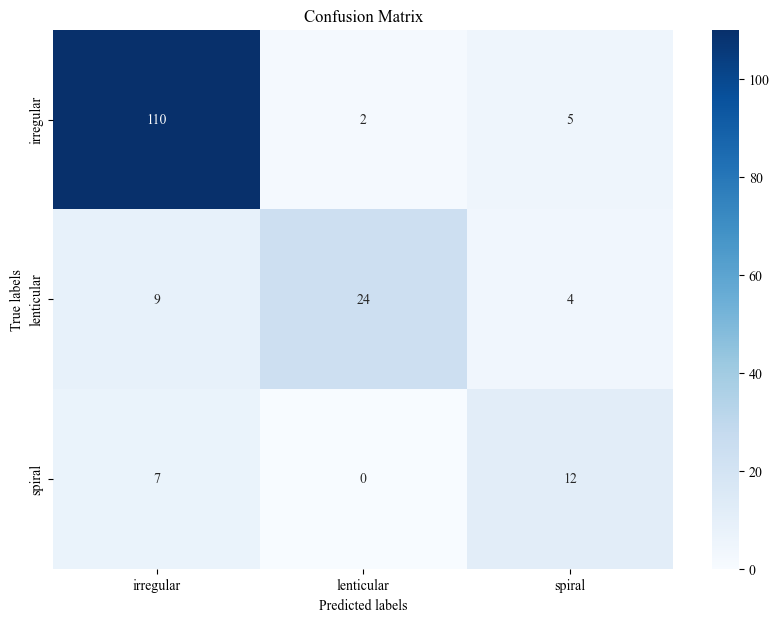

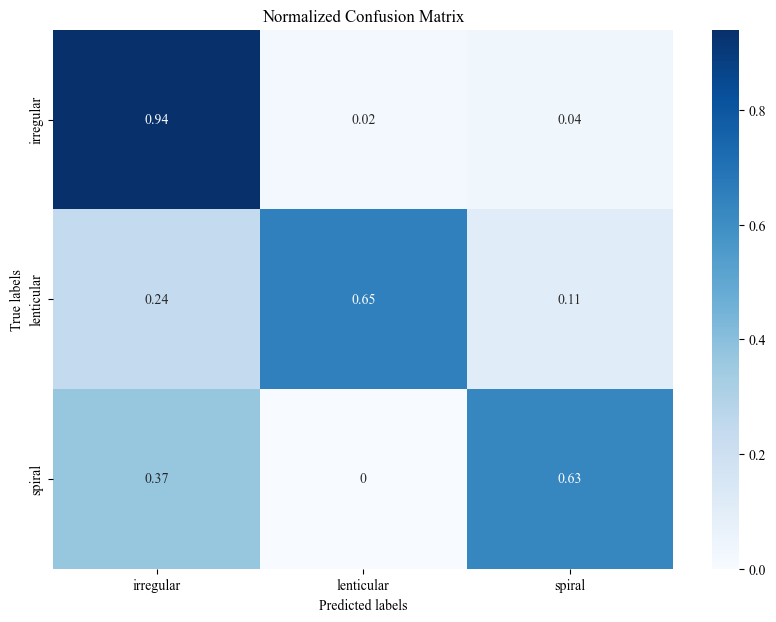

In [34]:
# Get cofnusion matrix
hub_unique_classes = np.unique(actual_test_preds)
cm = confusion_matrix(y_test, actual_test_preds, labels=hub_unique_classes)
cm_sum = np.sum(cm, axis=1)
cm_acc = np.round(cm / np.atleast_2d(cm_sum).T, 2)

# Plot the confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=hub_unique_classes, yticklabels=hub_unique_classes)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Plot the normalized confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(cm_acc, annot=True, fmt='g', cmap='Blues', xticklabels=hub_unique_classes, yticklabels=hub_unique_classes)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Normalized Confusion Matrix')
plt.show()